# Sign Language Image Classfication

In [1]:
# necessary imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, InputLayer, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
warnings.filterwarnings("ignore")

### Data Preprocessing

In [2]:
# Load the dataset
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
print(train_df.shape, test_df.shape)

(27455, 785) (7172, 785)


In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
print(sorted(train_df['label'].unique()))
print(sorted(test_df['label'].unique()))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 200]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [5]:
train_df = train_df[(train_df['label'] >= 0) & (train_df['label'] <= 24)]

print(sorted(train_df['label'].unique()))
print(sorted(test_df['label'].unique()))
print(train_df.shape, test_df.shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
(27454, 785) (7172, 785)


In [6]:
# Remap the labels so that the range is 0-23
original_labels = [i for i in range(25) if i!=9]
label_map = {orig: new for new, orig in enumerate(original_labels)}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

print(sorted(train_df['label'].unique()))
print(sorted(test_df['label'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [7]:
import string

label_names = [c for c in string.ascii_lowercase if c not in ['j','z']]
print(label_names)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [8]:
# Convert labels and images to np arrays (and normalize the images)
train_labels = train_df['label'].to_numpy()
test_labels = test_df['label'].to_numpy()
train_images = (train_df.drop(columns=['label']).to_numpy())/255.0
test_images = (test_df.drop(columns=['label']).to_numpy())/255.0
print(np.min(train_images), np.max(train_images))

0.0 1.0


In [9]:
from tensorflow.keras.utils import to_categorical

train_labels_encoded = to_categorical(train_labels, num_classes = 24)
test_labels_encoded = to_categorical(test_labels, num_classes = 24)

train_labels_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

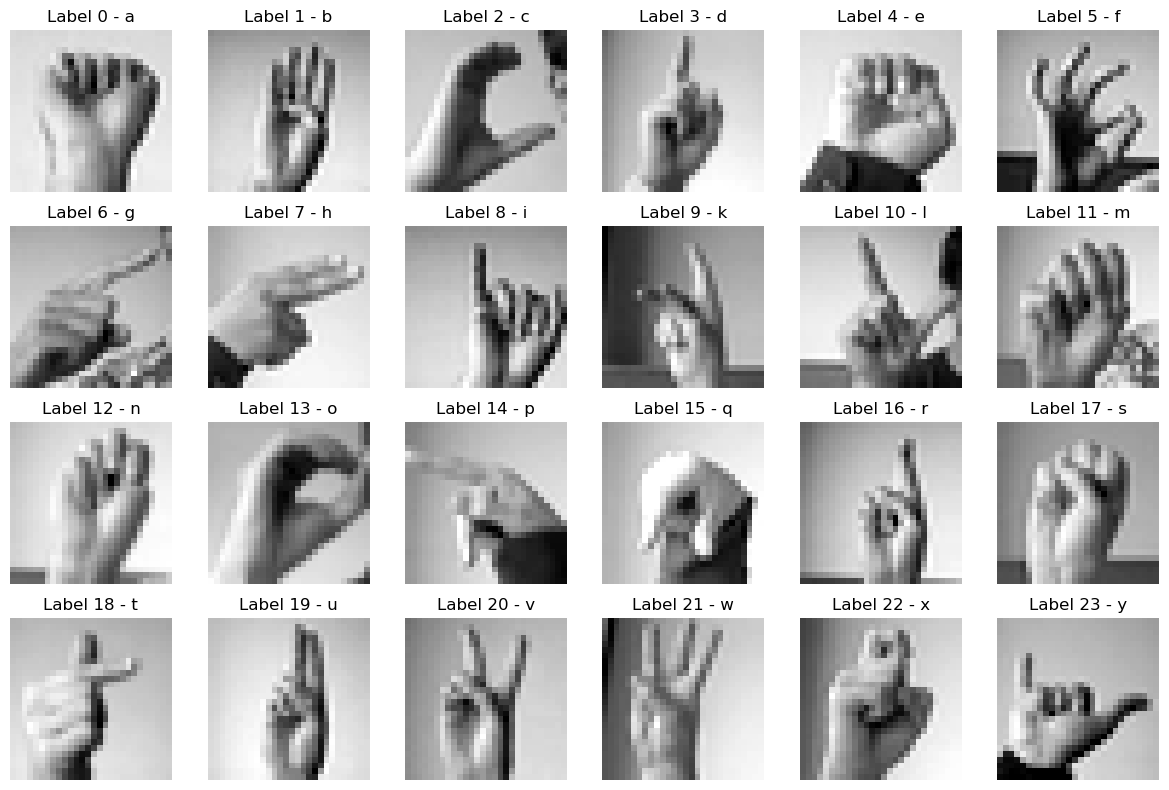

In [10]:
plt.figure(figsize=(12,8))
for i in range(24):
    idx = np.where(train_labels == i)[0][0]
    img = train_images[idx].reshape(28,28)
    plt.subplot(4,6,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label {i} - {label_names[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Neural Network Models

Transfer learning using **MobileNetV3Small** model and fine-tuning it on our dataset.

In [11]:
# Reshape input data to (28,28,3)
train_images_mb = train_images.reshape(-1,28,28,1)
train_images_mb = np.repeat(train_images_mb, 3, axis=-1)
test_images_mb = test_images.reshape(-1,28,28,1)
test_images_mb = np.repeat(test_images_mb, 3, axis=-1)

In [12]:
num_epochs = 50
batch_size = 128

In [13]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, UpSampling2D, GlobalAveragePooling2D

base_mb_model = MobileNetV3Small(input_shape=(56, 56, 3), include_top=False, weights='imagenet')

# Freeze model layers
for layer in base_mb_model.layers:
    layer.trainable = False

inputs = Input(shape=(28, 28, 3))
x = UpSampling2D(size=(2, 2))(inputs)
x = base_mb_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(24, activation='softmax')(x)
mb_model = tf.keras.Model(inputs=inputs, outputs=outputs)

mb_model.summary()

# Use a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=3*(len(train_images_mb)//batch_size),
    decay_rate=0.5,
    staircase=True
)

# Compile the model
mb_model.compile(
    optimizer=Nadam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
history = None
mb_checkpoint = ModelCheckpoint("mb_model.keras", save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = mb_model.fit(
    train_images_mb, train_labels_encoded,
    validation_split = 0.2,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[mb_checkpoint, early_stopping],
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 2, 2, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,144,136 (8.18 MB)

 Trainable params: 1,202,968 (4.59 MB)

 Non-trainable params: 941,168 (3.59 MB)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.4229 - loss: 1.8914 - val_accuracy: 0.0419 - val_loss: 10.5843
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8684 - loss: 0.3800 - val_accuracy: 0.0401 - val_loss: 8.6532
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9424 - loss: 0.1803 - val_accuracy: 0.0397 - val_loss: 17.7763
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9662 - loss: 0.1027 - val_accuracy: 0.1504 - val_loss: 21.0305
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9844 - loss: 0.0532 - val_accuracy: 0.1444 - val_loss: 20.2934
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9871 - loss: 0.0425 - val_accuracy: 0.2495 - val_loss: 8.4162
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9908 - loss: 0.0347 - val_accuracy: 0.2528 - val_loss: 11.9854
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9910 - loss: 0.0344 

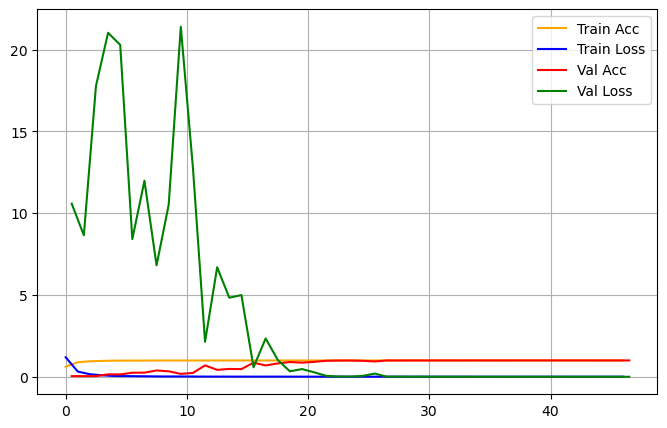

In [16]:
# function to plot the training history
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.show()

plot_history(history)

In [20]:
model_name = "mb_model.keras"
mb_model = tf.keras.models.load_model(model_name)

# Evaluate the model on the test set
test_loss1_mobilenet, test_acc1_mobilenet = mb_model.evaluate(test_images_mb, test_labels_encoded, verbose=0)
print(f"Model Mobile Net: Test accuracy: {test_acc1_mobilenet:.4f}")
print(test_loss1_mobilenet,test_acc1_mobilenet)

Model Mobile Net: Test accuracy: 0.9046
0.3460882306098938 0.904629111289978


In [21]:
# predict on test set
prediction_test = mb_model.predict(test_images_mb)
test_labels_pred = np.argmax(prediction_test, axis=1)

# Calculate accuracy for each label
label_accuracy = []
for id in range(len(label_names)):
    ids = np.where(test_labels == id)[0]
    correct = np.sum(test_labels_pred[ids] == id)
    accuracy = correct / len(ids)
    label_accuracy.append(accuracy)
    print(f"Label {label_names[id]}: {accuracy:.4f} ({correct}/{len(ids)})")

label_accuracy = np.array(label_accuracy)

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Label a: 1.0000 (331/331)
Label b: 0.9259 (400/432)
Label c: 0.9935 (308/310)
Label d: 0.9102 (223/245)
Label e: 0.8815 (439/498)
Label f: 0.9150 (226/247)
Label g: 0.8879 (309/348)
Label h: 0.9771 (426/436)
Label i: 0.9201 (265/288)
Label k: 0.7734 (256/331)
Label l: 1.0000 (209/209)
Label m: 0.8553 (337/394)
Label n: 0.7835 (228/291)
Label o: 0.7642 (188/246)
Label p: 0.9914 (344/347)
Label q: 1.0000 (164/164)
Label r: 0.9514 (137/144)
Label s: 0.9024 (222/246)
Label t: 0.7823 (194/248)
Label u: 0.8571 (228/266)
Label v: 0.8179 (283/346)
Label w: 0.9903 (204/206)
Label x: 0.9438 (252/267)
Label y: 0.9488 (315/332)


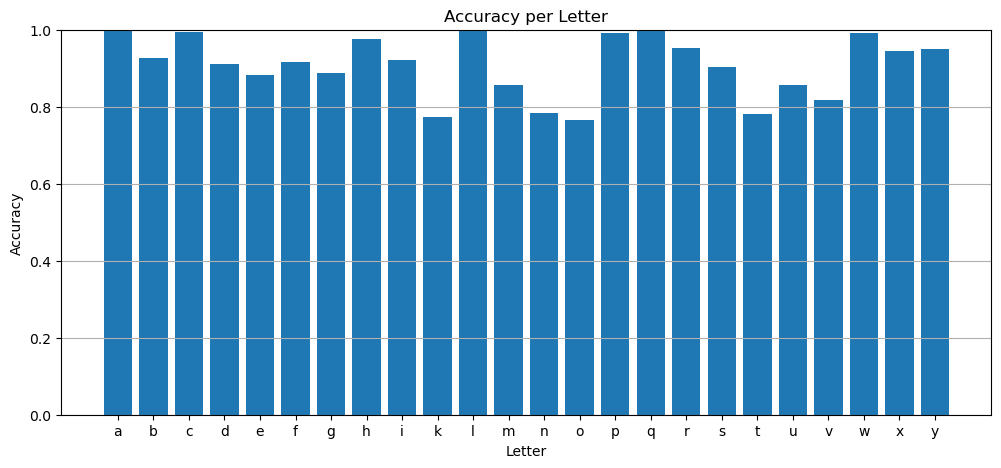

In [22]:
plt.figure(figsize=(12, 5))
plt.bar(label_names, label_accuracy)
plt.title("Accuracy per Letter")
plt.xlabel("Letter")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

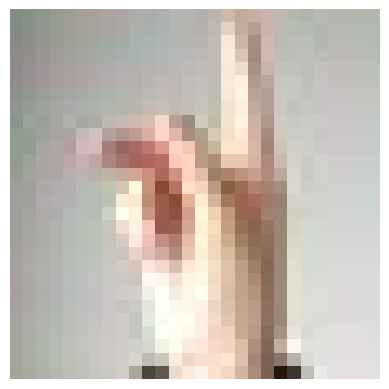

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted letter: k


In [23]:
img_path = 'challenge1.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (28, 28))
img = img.astype('float32')/ 255.0
img = np.expand_dims(img, axis=0)
plt.imshow(img[0])
plt.axis('off')
plt.show()

prediction = mb_model.predict(img)
predicted_class = np.argmax(prediction)
result_challenge1 = label_names[predicted_class]
print("Predicted letter:", result_challenge1)